### BigData & Blockchain Lab
#### BTC-USD Price Prediction as regression problem(Buy/Sell) with Deep LSTM NN.


#### Presented by @SAnbaee

In [2]:
import tensorflow as tf
import pandas as pd
from collections import deque
import random
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, LSTM, BatchNormalization
from matplotlib import pyplot as plt
import ta
from matplotlib import pyplot as plt

In [3]:

SEQ_LEN = 7 # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1 # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "BTC-USD"
EPOCHS = 30  # how many passes through our data
BATCH_SIZE = 64


In [4]:
def normalization(df):
    #df = df.drop("future", 1)  # don't need this anymore.
    df = df.drop("High", 1)  # don't need this anymore.
    df = df.drop("Low", 1)  # don't need this anymore.
    df = df.drop("Open", 1)  # don't need this anymore.
    
    for col in df.columns:  # go through all of the columns
        if col != "target":  # normalize all ... except for the target itself!
            df[col] =[float(e) for e in df[col]]
            df[col] = df[col].pct_change()  # pct changefor  "normalizes"
            df = df.replace([np.inf, -np.inf], None)
            df.dropna(inplace=True )  # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.
    
    df.dropna(inplace=True)  # cleanup again... jic.
    return df



In [5]:

# In[ ]:


def preprocess_df(df):
    
    df = normalization(df)
    sequential_data = []  # this is a list that will CONTAIN the sequences
    
    # These will be our actual sequences. 
    #they are made with deque, which keeps
    #the maximum length by popping out older 
    #values as new ones come in
    prev_days = deque(maxlen=SEQ_LEN)  

    for i in df.values:  # iterate over the values
    
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 10 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # i[-1] is the sequence target

    
    random.shuffle(sequential_data)  # shuffle for good measure.
    
    '''
    # for classification we need this part of codes
    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!

    lower = min(len(buys), len(sells))  # what's the shorter length?
    
    # for blancing dataset
    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys+sells  # add them together
    random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    '''
    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)


    
    return np.array(X), y  # return X and y...and make X a numpy array!



In [6]:
def classify(current, future):
    if float(future) > float(current):  # if the future price is higher than the current, that's a buy, or a 1
        return 1
    else:  # otherwise... it's a 0!
        return 0


In [7]:
filename = 'BTC-USD.csv'
dataset = filename
main_df = pd.read_csv(dataset )  # read in specific file
main_df['timestamp'] = main_df['Date'] #+' '+ main_df['time']

main_df['timestamp'] = pd.to_datetime(main_df['timestamp'])
main_df = main_df.sort_values('timestamp', axis = 0  )
main_df = main_df.set_index('timestamp')
main_df = main_df.drop('Date' ,1)
#main_df  = main_df.drop('time',1)


main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)



# add target 
main_df['target'] = main_df['Close'].shift(-FUTURE_PERIOD_PREDICT)
#main_df['target'] = list(map(classify, main_df['Close'], main_df['future']))


#test and train seprate
dates = sorted(main_df.index.values)  # get the dates
last_5pct = sorted(main_df.index.values)[-int(0.2*len(dates))]  # get the last 20% of the times

validation_main_df = main_df[(main_df.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = main_df[(main_df.index < last_5pct)]  # now the main_df is all the data up to the last 5%
print(main_df.head())
print(main_df.describe())



                    Open          High           Low         Close  \
timestamp                                                            
2019-08-31   9597.539063   9673.220703   9531.799805   9630.664063   
2019-09-01   9630.592773   9796.755859   9582.944336   9757.970703   
2019-09-02   9757.473633  10396.591797   9730.650391  10346.760742   
2019-09-03  10345.725586  10736.104492  10308.547852  10623.540039   
2019-09-04  10621.180664  10762.644531  10434.709961  10594.493164   

               Adj Close       Volume        target  
timestamp                                            
2019-08-31   9630.664063  11454806419   9757.970703  
2019-09-01   9757.970703  11445355859  10346.760742  
2019-09-02  10346.760742  17248102293  10623.540039  
2019-09-03  10623.540039  19384917988  10594.493164  
2019-09-04  10594.493164  16742664768  10575.533203  
               Open          High           Low         Close     Adj Close  \
count    294.000000    294.000000    294.000000    2

In [8]:
train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)
print(train_x.shape)
print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")


(285, 7, 3)
train data: 285 validation: 63
Dont buys: 0, buys: 0
VALIDATION Dont buys: 0, buys: 0


In [9]:
EPOCHS = 500  # how many passes through our data
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.


In [10]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.


model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(1))


In [11]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=opt,
   
)
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            67584     
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 128)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 32)                2

In [12]:
history = model.fit(
    train_x, np.array(train_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, np.array(validation_y)))


Train on 285 samples, validate on 63 samples
Epoch 1/500
285/285 [==============================] - 8s 30ms/sample - loss: 100.0077 - val_loss: 99.9996
Epoch 2/500
285/285 [==============================] - 0s 536us/sample - loss: 99.9948 - val_loss: 99.9992
Epoch 3/500
285/285 [==============================] - 0s 565us/sample - loss: 99.9893 - val_loss: 99.9986
Epoch 4/500
285/285 [==============================] - 0s 561us/sample - loss: 99.9821 - val_loss: 99.9981
Epoch 5/500
285/285 [==============================] - 0s 575us/sample - loss: 99.9762 - val_loss: 99.9975
Epoch 6/500
285/285 [==============================] - 0s 603us/sample - loss: 99.9724 - val_loss: 99.9968
Epoch 7/500
285/285 [==============================] - 0s 554us/sample - loss: 99.9677 - val_loss: 99.9960
Epoch 8/500
285/285 [==============================] - 0s 572us/sample - loss: 99.9608 - val_loss: 99.9950
Epoch 9/500
285/285 [==============================] - 0s 694us/sample - loss: 99.9540 - val_loss: 

285/285 [==============================] - 0s 614us/sample - loss: 96.8318 - val_loss: 97.4022
Epoch 70/500
285/285 [==============================] - 0s 529us/sample - loss: 96.6322 - val_loss: 97.1611
Epoch 71/500
285/285 [==============================] - 0s 547us/sample - loss: 96.5315 - val_loss: 96.8252
Epoch 72/500
285/285 [==============================] - 0s 529us/sample - loss: 96.3342 - val_loss: 96.6133
Epoch 73/500
285/285 [==============================] - 0s 526us/sample - loss: 96.2055 - val_loss: 96.5000
Epoch 74/500
285/285 [==============================] - 0s 515us/sample - loss: 96.0820 - val_loss: 96.3900
Epoch 75/500
285/285 [==============================] - 0s 537us/sample - loss: 95.9480 - val_loss: 96.2822
Epoch 76/500
285/285 [==============================] - 0s 512us/sample - loss: 95.8050 - val_loss: 96.1879
Epoch 77/500
285/285 [==============================] - 0s 526us/sample - loss: 95.6239 - val_loss: 96.1000
Epoch 78/500
285/285 [===================

285/285 [==============================] - 0s 544us/sample - loss: 67.5268 - val_loss: 72.6842
Epoch 145/500
285/285 [==============================] - 0s 522us/sample - loss: 68.0197 - val_loss: 71.0914
Epoch 146/500
285/285 [==============================] - 0s 621us/sample - loss: 66.2668 - val_loss: 68.4305
Epoch 147/500
285/285 [==============================] - 0s 656us/sample - loss: 65.7175 - val_loss: 67.3870
Epoch 148/500
285/285 [==============================] - 0s 645us/sample - loss: 64.1776 - val_loss: 68.6872
Epoch 149/500
285/285 [==============================] - 0s 614us/sample - loss: 64.6492 - val_loss: 69.8996
Epoch 150/500
285/285 [==============================] - 0s 526us/sample - loss: 64.9051 - val_loss: 73.5431
Epoch 151/500
285/285 [==============================] - 0s 526us/sample - loss: 66.6854 - val_loss: 75.8583
Epoch 152/500
285/285 [==============================] - 0s 617us/sample - loss: 67.2356 - val_loss: 73.1549
Epoch 153/500
285/285 [==========

285/285 [==============================] - 0s 586us/sample - loss: 18.4131 - val_loss: 28.4803
Epoch 220/500
285/285 [==============================] - 0s 537us/sample - loss: 19.3237 - val_loss: 28.1640
Epoch 221/500
285/285 [==============================] - 0s 544us/sample - loss: 19.3778 - val_loss: 28.1327
Epoch 222/500
285/285 [==============================] - 0s 544us/sample - loss: 19.0540 - val_loss: 27.1267
Epoch 223/500
285/285 [==============================] - 0s 530us/sample - loss: 16.4592 - val_loss: 26.2848
Epoch 224/500
285/285 [==============================] - 0s 515us/sample - loss: 19.5950 - val_loss: 25.9643
Epoch 225/500
285/285 [==============================] - 0s 519us/sample - loss: 17.8453 - val_loss: 25.7696
Epoch 226/500
285/285 [==============================] - 0s 526us/sample - loss: 19.0134 - val_loss: 26.6649
Epoch 227/500
285/285 [==============================] - 0s 522us/sample - loss: 20.3257 - val_loss: 26.1460
Epoch 228/500
285/285 [==========

285/285 [==============================] - 0s 540us/sample - loss: 28.2541 - val_loss: 26.9070
Epoch 295/500
285/285 [==============================] - 0s 533us/sample - loss: 27.3083 - val_loss: 27.2188
Epoch 296/500
285/285 [==============================] - 0s 512us/sample - loss: 26.3217 - val_loss: 27.3751
Epoch 297/500
285/285 [==============================] - 0s 537us/sample - loss: 23.2385 - val_loss: 27.7021
Epoch 298/500
285/285 [==============================] - 0s 526us/sample - loss: 22.5498 - val_loss: 28.0213
Epoch 299/500
285/285 [==============================] - 0s 522us/sample - loss: 20.7139 - val_loss: 28.3460
Epoch 300/500
285/285 [==============================] - 0s 526us/sample - loss: 19.2177 - val_loss: 28.8333
Epoch 301/500
285/285 [==============================] - 0s 533us/sample - loss: 18.9364 - val_loss: 27.2296
Epoch 302/500
285/285 [==============================] - 0s 519us/sample - loss: 18.8655 - val_loss: 26.8276
Epoch 303/500
285/285 [==========

285/285 [==============================] - 0s 551us/sample - loss: 16.8440 - val_loss: 22.4607
Epoch 370/500
285/285 [==============================] - 0s 533us/sample - loss: 17.7821 - val_loss: 22.5957
Epoch 371/500
285/285 [==============================] - 0s 529us/sample - loss: 16.9417 - val_loss: 22.4551
Epoch 372/500
285/285 [==============================] - 0s 515us/sample - loss: 19.2937 - val_loss: 22.5529
Epoch 373/500
285/285 [==============================] - 0s 522us/sample - loss: 20.7724 - val_loss: 22.8066
Epoch 374/500
285/285 [==============================] - 0s 533us/sample - loss: 21.3101 - val_loss: 23.0352
Epoch 375/500
285/285 [==============================] - 0s 515us/sample - loss: 19.2127 - val_loss: 23.0042
Epoch 376/500
285/285 [==============================] - 0s 522us/sample - loss: 18.8101 - val_loss: 22.9991
Epoch 377/500
285/285 [==============================] - 0s 529us/sample - loss: 20.6797 - val_loss: 23.1061
Epoch 378/500
285/285 [==========

285/285 [==============================] - 0s 568us/sample - loss: 17.6141 - val_loss: 20.8593
Epoch 445/500
285/285 [==============================] - 0s 526us/sample - loss: 18.3985 - val_loss: 21.1297
Epoch 446/500
285/285 [==============================] - 0s 526us/sample - loss: 17.9213 - val_loss: 21.0878
Epoch 447/500
285/285 [==============================] - 0s 533us/sample - loss: 16.9064 - val_loss: 21.2197
Epoch 448/500
285/285 [==============================] - 0s 526us/sample - loss: 19.5111 - val_loss: 21.4267
Epoch 449/500
285/285 [==============================] - 0s 529us/sample - loss: 20.5848 - val_loss: 21.6002
Epoch 450/500
285/285 [==============================] - 0s 526us/sample - loss: 20.2613 - val_loss: 21.6992
Epoch 451/500
285/285 [==============================] - 0s 537us/sample - loss: 16.4546 - val_loss: 21.8210
Epoch 452/500
285/285 [==============================] - 0s 526us/sample - loss: 18.4177 - val_loss: 22.0746
Epoch 453/500
285/285 [==========

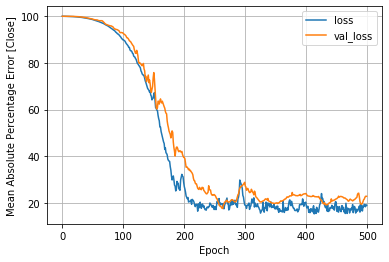

In [15]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error [Close]')
  plt.legend()
  plt.grid(True)


plot_loss(history)
